<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 6th exercise: <font color="#C70039">Work with Autoencoders for anomaly detection</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: Mathis Loevenich
* Date:   14.11.2022
* Matr. No.: 11157363 

<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" style="float: center;" width="700">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
Autoencoder is an unsupervised artificial neural network (ANN) that learns how to efficiently compress and encode data and then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

An Autoencoder reduces data dimensions by learning how to ignore the noise in the data and thus outliers.
In the section above, you can seen an example of the input/output image from the MNIST dataset to an Autoencoder.

#### Autoencoder Components:
An Autoencoder consists of four main parts:

1. Encoder: In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.

2. Bottleneck: which is the layer that contains the compressed representation of the input data. This is the lowest possible dimensions of the input data. The bottlneck is also called latent vector. The concept of the latent space and latent vectors becomes important later on as we move forward to understand Generative Models. 

3. Decoder: In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.

4. Reconstruction Loss: This is the method that measures how well the decoder is performing and how close the output is to the original input.

As always in ANNs, the training itself involves back propagation in order to minimize the network’s reconstruction loss.

Due to this features of an Autoencoder the use cases are manyfold. One of the obviously is anomaly detection. 

#### Autoencoder Architecture:

The network architecture for Autoencoders can vary between simple Feed Forward networks, Recurrent Neural Networks (LSTM) or Convolutional Neural Networks (CNN) depending on the use case. 

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * the example below shows how to use an autoencoder for anomaly detection

4. <font color=green>Develop an Autoencoder for Domain Adaptation (Me -> Walter White ). You can of course also take own data, e.g. a photo of yours and someone else.</font>
5. Set at least the following hyperparameters for training (epochs=100000, shuffle=True).
6. Implement a CNN for working out important features for the adaptation. If you feel lost in the exercise, please visit the sample solution.
7. There is also an implementation of data augmentation that helps you building up your data set from one single "original" image. 
---------------------------------

### Auto-Encoding
If you have correlated input data, the auto-encoder method will work very well because the encoding operation relies on the correlated features to compress the data.
Let’s consider that an auto-encoder is trained on the MNIST dataset. 
As you know already, using a simple FeedForward neural network, this can be done by building a simple 6 layers network as below:

In [1]:
import numpy as np
import keras
from   keras.datasets import mnist
from   keras.models import Sequential, Model
from   keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from   keras import optimizers
from   keras.optimizers import Adam

# from keras.preprocessing import image 
from keras.utils import load_img, img_to_array # tensorflow > 2.8 works with this

import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tqdm import tqdm
import time
import numpy as np
import cv2

In [133]:
# load the inbuild mnist data set (8bit grayscale digits)
# https://en.wikipedia.org/wiki/MNIST_database
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# normalize the training and the validation data set
train_x = x_train.reshape(60000, 784) / 255
val_x = x_test.reshape(10000, 784) / 255

# build the auto-encoding layers
autoencoder = Sequential()
autoencoder.add(Dense(512,  activation='elu', input_shape=(784,)))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(10,   activation='linear', name="bottleneck"))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(512,  activation='elu'))
autoencoder.add(Dense(784,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

'''
NOTE:
-----
The Exponential Linear Unit (ELU) is an activation function for neural networks. 
In contrast to ReLUs (which you know), ELUs have negative values which allows them to push mean unit 
activations closer to zero like batch normalization but with lower computational complexity.
'''    

# train the model and finally assign the encoding to the decoder
'''
NOTE:
-----
make sure you understand, that you are training on train_x and not on train_y but train_x again for the reconstruction
the same for the validation (val_x, val_x)
'''
trained_model = autoencoder.fit(
    train_x, train_x, 
    batch_size=1024, epochs=10, verbose=1, 
    validation_data=(val_x, val_x)
)
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

encoded_data = encoder.predict(train_x)  # bottleneck representation

decoded_output = autoencoder.predict(train_x)        # reconstruction
encoding_dim = 10

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

Epoch 1/10
59/59 [==============================] - 7s 97ms/step - loss: 0.0757 - val_loss: 0.0487
Epoch 2/10
59/59 [==============================] - 6s 100ms/step - loss: 0.0418 - val_loss: 0.0347
Epoch 3/10
59/59 [==============================] - 6s 94ms/step - loss: 0.0319 - val_loss: 0.0286
Epoch 4/10
59/59 [==============================] - 6s 99ms/step - loss: 0.0278 - val_loss: 0.0261
Epoch 5/10
59/59 [==============================] - 5s 91ms/step - loss: 0.0256 - val_loss: 0.0242
Epoch 6/10
59/59 [==============================] - 6s 95ms/step - loss: 0.0240 - val_loss: 0.0228
Epoch 7/10
59/59 [==============================] - 6s 95ms/step - loss: 0.0228 - val_loss: 0.0218
Epoch 8/10
59/59 [==============================] - 5s 83ms/step - loss: 0.0218 - val_loss: 0.0208
Epoch 9/10
59/59 [==============================] - 8s 136ms/step - loss: 0.0209 - val_loss: 0.0201
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step


As you can see in the output, the last reconstruction loss/error for the validation set is approx. 0.0197, which is great. 
Now, if we pass any normal image from the MNIST dataset, the reconstruction loss will be very low (< 0.02) BUT if we tried to pass any other different image (outlier / anomaly), we will get a high reconstruction loss value because the network failed to reconstruct the image/input that is considered an anomaly.

Notice in the code above, you can use only the encoder part to compress some data or images and you can also only use the decoder part to decompress the data by loading the decoder layers.

#### Auto-Encoders for Anomaly Detection
Now, let’s do some anomaly detection. The code below uses two different images to predict the anomaly score (reconstruction error) using the autoencoder network we trained above. 

The first image is from the MNIST and the result is error=2.46241018. This means that the image is not an anomaly. The second image (yoda.png) obviously does not belong to the training dataset and the result is: error=2727.0718. This high error means that the image is an anomaly. Even the third image. The same concept applies to any type of dataset.

In [135]:
# take an image from the validation data set or the training data set, respectively
input_img = val_x[50] 
input_img_flat = input_img.reshape(1,784)

target_data = autoencoder.predict(input_img_flat)

dist = np.linalg.norm(input_img_flat - target_data, axis=-1)

print(dist)

1/1 [==============================] - 0s 78ms/step
[2.77445769]


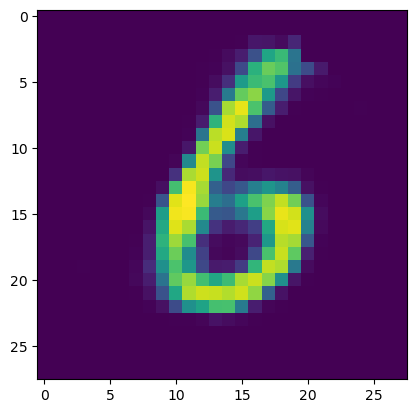

In [136]:
plt.imshow(target_data.reshape(28, 28))

In [137]:
# Now take Master Yoda as the test image. The error score will be very high (error=2727.0718)

img = load_img("./data/yoda.png", target_size=(28, 28), color_mode = "grayscale")
input_img = img_to_array(img)

input_img_flat = input_img.reshape(1,784)
target_data = autoencoder.predict(input_img_flat)
dist = np.linalg.norm(input_img_flat - target_data, axis=-1)
print(dist)

1/1 [==============================] - 0s 21ms/step
[2727.4253]


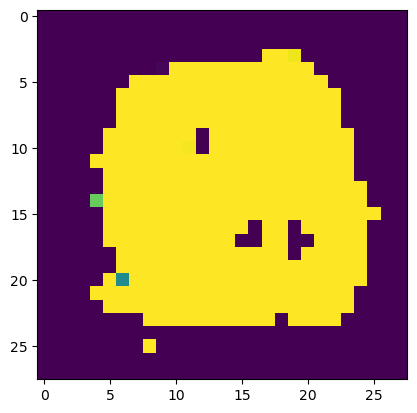

In [138]:
plt.imshow(target_data.reshape(28,28))

In [139]:
''' 
Now take a Mnist image which is taken from the google image search and although it is super similar to the training data
it does not belong to the same data distribution the auto-encoder was trained on. 
It produces an error almost as high as yoda.png (error=2551.99)
This makes autoencoders being a very robust technique for anomaly detection.
'''

img = load_img("./data/similarMnistNumber.jpg", target_size=(28, 28), color_mode = "grayscale")
input_img = img_to_array(img)

input_img_flat = input_img.reshape(1,784)
target_data = autoencoder.predict(input_img_flat)
dist = np.linalg.norm(input_img_flat - target_data, axis=-1)

print(dist)

1/1 [==============================] - 0s 20ms/step
[2552.0166]


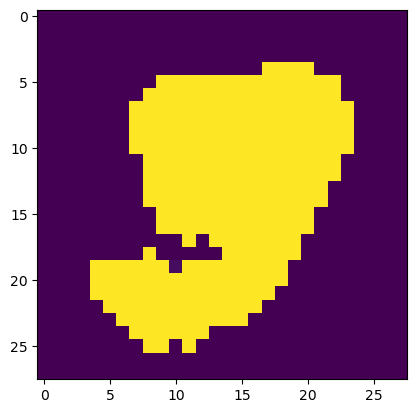

In [140]:
plt.imshow(target_data.reshape(28,28))

In [6]:
def gen_augmented_pictures(img_folder, num=50):
    image_names=os.listdir(img_folder)

    for filename in image_names:
        if filename.startswith("."):
            continue
        print(filename)

        file_path = os.path.join(img_folder, filename)
        save_to_dir = os.path.join(img_folder, f'augmented_{filename.split(".")[0]}')

        if not os.path.exists(save_to_dir):
            os.mkdir(save_to_dir)

        img = load_img(file_path) 
        x = img_to_array(img) 
        # Reshape the input image 
        x = x.reshape((1, ) + x.shape)  
        
        datagen = ImageDataGenerator(
                    rotation_range=90,
                    horizontal_flip=True,
                    vertical_flip=True,
                    width_shift_range=45.0,
                    height_shift_range=45.0
        ) 

        i = 1
        # generate n new augmented images 
        for batch in datagen.flow(
            x, 
            batch_size = 1, 
            save_to_dir = save_to_dir, 
            save_format ='jpg'
        ):
            i += 1
            if i > num:
                break

In [179]:
gen_augmented_pictures("data/me_yoda", num=500)

me.JPG
yoda.png


In [9]:
def get_conv_autoencoder():
    SIZE = 256
    
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    model.summary()
    
    return model

In [63]:
def get_augmented_training_data(input_path, output_path, color=True, SIZE=64):
    # import input img
    input_img_data=[]
    files=os.listdir(input_path)
    # read all images in the folder (different rotations and flips of the original)
    for i in tqdm(files):
        img=cv2.imread(input_path+'/'+i, int(color))   #Change 0 to 1 for color images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Changing BGR to RGB to show images in true colors
        img=cv2.resize(img,(SIZE, SIZE))
        input_img_data.append(img_to_array(img))
    
    # import output_img
    output_img_data=[]
    files=os.listdir(output_path)
    # read all images in the folder (same rotations and flips as img)
    for i in tqdm(files):
        img=cv2.imread(output_path+'/'+i, int(color))  #Change 0 to 1 for color images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Changing BGR to RGB to show images in true colors
        img=cv2.resize(img,(SIZE, SIZE))
        output_img_data.append(img_to_array(img))

    input_img_array = np.reshape(input_img_data, (len(input_img_data), SIZE, SIZE, 3))
    input_img_array = input_img_array.astype('float32') / 255. # normalize
    
    output_img_array= np.reshape(output_img_data, (len(output_img_data), SIZE, SIZE, 3))
    output_img_array = output_img_array.astype('float32') / 255. # normalize
    
    return input_img_array, output_img_array

In [11]:
def train_conv_model(model, data, epochs=10):
    model.fit(
        data[0],data[1],
        epochs=epochs, 
        shuffle=True
    )

In [12]:
input_path = './data/me_yoda/augmented_me/'
output_path = './data/me_yoda/augmented_yoda/'

In [14]:
model = get_conv_autoencoder()
data = get_augmented_training_data(input_path, output_path, SIZE=256)
epochs = 10
train_conv_model(model, data, epochs)
# save the model
model.save("domain_adapt_autoenc_epochs." + str(epochs) + ".model")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 8)       2312      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 8)         584       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 8)       

100%|██████████| 50/50 [00:00<00:00, 136.61it/s]


Epoch 1/10
2/2 [==============================] - 9s 3s/step - loss: 0.1146 - accuracy: 0.2142
Epoch 2/10
2/2 [==============================] - 8s 3s/step - loss: 0.1030 - accuracy: 0.1445
Epoch 3/10
2/2 [==============================] - 8s 2s/step - loss: 0.0854 - accuracy: 0.0887
Epoch 4/10
2/2 [==============================] - 7s 3s/step - loss: 0.0652 - accuracy: 0.0679
Epoch 5/10
2/2 [==============================] - 7s 2s/step - loss: 0.0581 - accuracy: 0.4249
Epoch 6/10
2/2 [==============================] - 5s 2s/step - loss: 0.0577 - accuracy: 0.7313
Epoch 7/10
2/2 [==============================] - 6s 2s/step - loss: 0.0490 - accuracy: 0.7513
Epoch 8/10
2/2 [==============================] - 6s 2s/step - loss: 0.0459 - accuracy: 0.7436
Epoch 9/10
2/2 [==============================] - 5s 2s/step - loss: 0.0457 - accuracy: 0.7111
Epoch 10/10
2/2 [==============================] - 5s 2s/step - loss: 0.0451 - accuracy: 0.7201


INFO:tensorflow:Assets written to: domain_adapt_autoenc_epochs.10.model/assets


INFO:tensorflow:Assets written to: domain_adapt_autoenc_epochs.10.model/assets


In [20]:
def get_test_data(path, color=True, SIZE=64):
    test_img_data=[]

    test_img = cv2.imread(path, int(color))   #Change 0 to 1 for color images
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) #Changing BGR to RGB to show images in true colors
    test_img = cv2.resize(test_img,(SIZE, SIZE))
    test_img_data.append(img_to_array(test_img))

    test_img_array = np.reshape(test_img_data, (len(test_img_data), SIZE, SIZE, 3))
    test_img_array = test_img_array.astype('float32') / 255. # normalize
    return test_img_array

output of test image
1/1 [==============================] - 0s 134ms/step


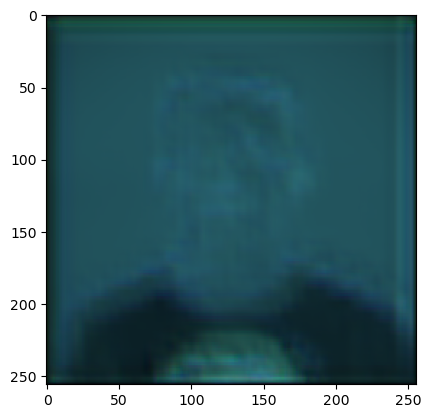

In [21]:
print("output of test image")
pred = model.predict(get_test_data('./data/me_yoda/me.jpg', SIZE=256))
plt.imshow(pred[0].reshape(256, 256, 3))
plt.show()

### Application of the simple Autoencoder

In [178]:
# load the inbuild mnist data set (8bit grayscale digits)
# https://en.wikipedia.org/wiki/MNIST_database
SIZE=64
x_train, x_test = get_augmented_training_data(input_path, output_path, color=False)


# normalize the training and the validation data set
train_x = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) / 255
val_x = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))) / 255

encoding_dim = 64

# build the auto-encoding layers
autoencoder = Sequential()
autoencoder.add(Dense(1024,  activation='elu', input_shape=(SIZE, SIZE, 3)))
autoencoder.add(Dense(256,  activation='elu'))
autoencoder.add(Dense(encoding_dim,   activation='linear', name="bottleneck"))
autoencoder.add(Dense(256,  activation='elu'))
autoencoder.add(Dense(1024,  activation='elu'))
autoencoder.add(Dense(SIZE**2 * 3,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

trained_model = autoencoder.fit(
    train_x, train_x, 
    batch_size=1024, epochs=100,
    shuffle=True,
    validation_data=(val_x, val_x)
)

encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(train_x)  # bottleneck representation

decoded_output = autoencoder.predict(train_x)        # reconstruction


# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

FileNotFoundError: [Errno 2] No such file or directory: './data/me_yoda/augmented_me/'

100%|██████████| 50/50 [00:00<00:00, 210.00it/s]


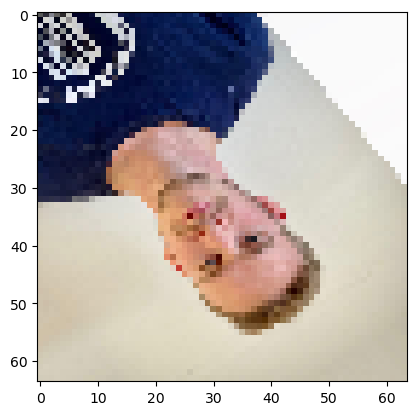

1/1 [==============================] - 0s 44ms/step


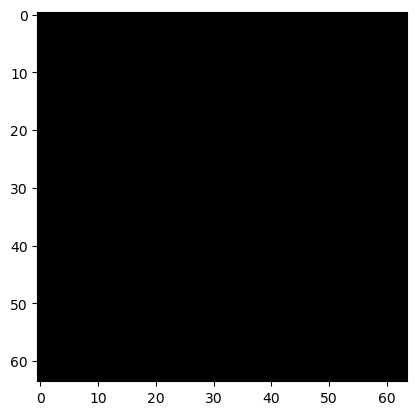

In [168]:
# After training, you need to provide the input and you can plot the results using the following code :
x_train, x_test = get_augmented_training_data(input_path, output_path)

test_data = get_test_data('./data/me_yoda/me.jpg', SIZE=64)
test_data_flat = x_train[0].reshape(1, SIZE**2 *3)

plt.imshow(test_data_flat.reshape(SIZE, SIZE, 3))
plt.show()

target_data = autoencoder.predict(test_data_flat)

plt.imshow(target_data.reshape(SIZE, SIZE, 3))
plt.show()